## MobileNet Model Via Pytorch

by: Alvin Zheng and Nat Efrat-Henrici

This notebook contains code for training the Pytorch built-in MobileNet model on the tiny-imagenet dataset.

In [1]:
# Get necessary packages
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch as torch
import numpy as np
import os

from pathlib import Path
import pickle
import gzip
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
from PIL import Image
import glob
import torchvision.transforms as transforms
import cv2

## Set up data and preprocessing

In [2]:
datapath = "./tiny-imagenet-200/"
trainpath = datapath + "train/"
pathV = datapath + "val/"
classIDs = os.listdir(trainpath)
classIDDict = {}
for i in range(len(classIDs)):
    classIDDict[classIDs[i]] = i

# Dataset parameters
imageClassCount = len(classIDs)
imagesPerClass = 500 
imageCount = imageClassCount  * imagesPerClass
imageHeight = 64
targetDim = 224
imageWidth = imageHeight
channels = 3
imageSize = imageHeight * imageWidth * channels

# Turn single-channel images into 3-channel images
def stackImage(image):
    return np.stack((im,)*channels, axis=-1)

# Helper function for resizing and normalizing images
def processImage(image):
    if (len(image.shape) < channels):
        image = stackImage(image)
    asfloat = image.astype('float32')
    resized = cv2.resize(asfloat, dsize=(targetDim,targetDim), interpolation=cv2.INTER_CUBIC)
    rolled = np.rollaxis(resized, 2, 0)
    tensor = torch.tensor(rolled)
    normalized = normalize(tensor)
    numpied = normalized.numpy()[:,:,:]
    return numpied

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

#### Read in the training data

In [3]:
images = np.zeros((imageCount, channels, targetDim, targetDim), dtype="float32")
labels = np.zeros(imageCount, dtype=int)
for i in range(len(classIDs)):
    fileNames = glob.glob(trainpath+classIDs[i]+"/images/*.JPEG")
    for j in range(imagesPerClass):
        im = mpimg.imread(fileNames[j].replace("\\", "/"))
        im = processImage(im)
        index = i * imagesPerClass + j
        images[index] = im
        labels[index] = i

In [14]:
# Convert numpy array into Pytorch tensor
x_train, y_train = map(
    torch.as_tensor, (images, labels))

# Create Pytorch Dataset
train_ds = TensorDataset(x_train, y_train)

# Split data into training and valid
train_ds, valid_ds = torch.utils.data.random_split(train_ds, [90000,10000], generator=torch.Generator().manual_seed(42))

In [6]:
#Create DataLoader
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

def preprocess1(x):
    return x.view(-1, channels, targetDim, targetDim)

def preprocess2(x, y):
    return x.view(-1, channels, targetDim, targetDim), y

#### Define our loss function and accuracy 


In [7]:
loss_func = F.cross_entropy

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

### Training loop

In [8]:
# Loss for a full batch
def loss_batch(model, loss_func, xb, yb, opt=None):
    yb = yb.long()
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)
                
# Fit model to data
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    # Training loop
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for xb, yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                val_loss, nums = loss_batch(model, loss_func, xb, yb)
                epoch_val_loss +=  val_loss
            epoch_val_loss /= nums
        print(epoch, epoch_val_loss)

In [9]:
# Hyperparameters
bs = 128 # batch size
epochs = 10  # how many epochs to train for
# lr is initialized after running lr_finder

In [15]:
#Get Model
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)

dev = 'cpu:0'
if torch.cuda.is_available(): 
    dev = "cuda:0" 
device = torch.device(dev)
model.to(device);

# Get dataloaders
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)


Using cache found in /home/nefrathenrici/.cache/torch/hub/pytorch_vision_v0.6.0


### Load Model Weights

In [16]:
model.load_state_dict(torch.load("./weights/MobileNet_38_1.37e-06"))
model.eval();

### Learning Rate Finder

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.37E-06


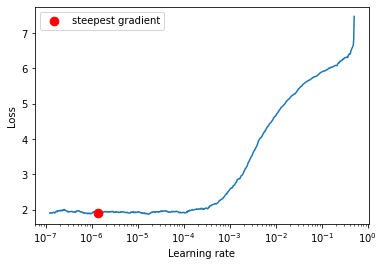

In [38]:
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device=dev)
lr_finder.range_test(train_dl, end_lr=100, num_iter=1000)
# lr_finder.range_test(train_dl, val_loader=valid_dl, end_lr=1, num_iter=200, step_mode="linear")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

### Training!

In [12]:
lr = 1.37E-06

# Set Optimizer according to the plot above
opt = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)

# Train!
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

KeyboardInterrupt: 

In [17]:
# Save model weights
weight_path = f"./weights/MobileNet_38_{lr}"
torch.save(model.state_dict(), weight_path)

In [18]:
val_acc = 0
counter = 0
with torch.no_grad():
    for xb, yb in valid_dl:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        val_acc += accuracy(out, yb)
        counter += 1
print(val_acc/counter)

tensor(0.6026, device='cuda:0')


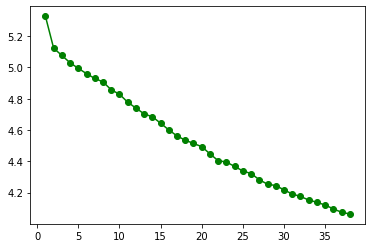

In [19]:
# Valid loss over time
epochs = list(range(1,39))
val_loss_list = [5.327650837600231,5.123415552079678,5.077155344188213,5.029857516288757,4.994525603950024,
                 4.960616514086723,4.929780952632427,4.908065341413021,4.8573076874017715,4.829350188374519,
                 4.778297625482082,4.740628458559513,4.703521311283112,4.6850893795490265,4.6439583748579025,
                 4.600932039320469,4.562484830617905,4.535249777138233,4.5144001096487045,4.494154617190361,
                 4.448036469519138,4.404275454580784,4.39578827470541,4.3673428520560265,4.338729187846184,
                 4.322137698531151,4.282575152814388,4.253854893147945,4.245316609740257,4.217824503779411,
                 4.191524356603622,4.175556048750877,4.153157740831375,4.1385044902563095,4.120686054229736,
                 4.09644078463316,4.074280813336372,4.063966669142246]
plt.plot(epochs, val_loss_list, 'go-')
plt.show()

In [66]:
# Code for cleaning up CUDA cache in case of memory usage issues
torch.cuda.set_device('cuda:0')
torch.cuda.empty_cache()
import gc
gc.collect()